In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.models as models

from torchvision.datasets.mnist import MNIST, read_image_file, read_label_file
from torchvision.transforms import v2, transforms as transforms

from amnist import AMNIST

import lightning as L
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.loggers import CSVLogger

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/manjunathshettar/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/manjunathshettar/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feed

In [2]:
torch.manual_seed(19)
L.seed_everything(seed = 19)

Global seed set to 19


19

In [3]:
device = torch.device('mps')

In [4]:
mnist_train = MNIST(root='../data', train=True, download=False)
mnist_test = MNIST(root='../data', train=False, download=False)

In [5]:
small_dataset_size_train = 5000
small_dataset_size_test = 1000

# Create subsets for training and testing
train_indices = torch.randperm(len(mnist_train))[:small_dataset_size_train]
test_indices = torch.randperm(len(mnist_test))[:small_dataset_size_test]

In [6]:
small_mnist_train = Subset(mnist_train, train_indices)
small_mnist_test = Subset(mnist_test, test_indices)

In [7]:
original_train_dataset = AMNIST(small_mnist_train, transformed=False)
original_test_dataset = AMNIST(small_mnist_test, transformed=False)

In [8]:
original_train_loader = DataLoader(original_train_dataset, batch_size=64, shuffle=True, num_workers=8)
original_test_loader = DataLoader(original_test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [9]:
class CNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_input_size = 64 * 7 * 7
        
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        values = {"training_loss": loss, "acc": acc}
        self.log_dict(values, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        values = {"test_loss": loss, "acc": acc}
        self.log_dict(values, prog_bar=True, on_epoch=True)
        return loss

In [10]:
original = CNN().to(device)

In [11]:
trainer = L.Trainer(max_epochs=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(original, original_train_loader)
original_train_info = trainer.callback_metrics


  | Name  | Type             | Params
-------------------------------------------
0 | conv1 | Conv2d           | 320   
1 | conv2 | Conv2d           | 18.5 K
2 | pool  | MaxPool2d        | 0     
3 | fc1   | Linear           | 401 K 
4 | fc2   | Linear           | 1.3 K 
5 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
trainer.test(original, original_test_loader)
original_test_info = trainer.callback_metrics

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           acc              0.9660000205039978
        test_loss           0.14241525530815125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [14]:
original_train_info

{'training_loss': tensor(0.0177),
 'training_loss_step': tensor(0.1870),
 'acc': tensor(0.9962),
 'acc_step': tensor(0.8750),
 'training_loss_epoch': tensor(0.0177),
 'acc_epoch': tensor(0.9962)}

In [15]:
transformed_train = AMNIST(small_mnist_train, transformed=True)
transformed_test = AMNIST(small_mnist_test, transformed=True)

transformed_train_loader = DataLoader(transformed_train, batch_size=64, shuffle=True, num_workers=8)
transformed_test_loader = DataLoader(transformed_test, batch_size=64, shuffle=False, num_workers=8)

In [16]:
transformed = CNN().to(device)

In [17]:
transformed_trainer = L.Trainer(max_epochs=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
transformed_trainer.fit(transformed, transformed_train_loader)
transformed_train_info = transformed_trainer.callback_metrics


  | Name  | Type             | Params
-------------------------------------------
0 | conv1 | Conv2d           | 320   
1 | conv2 | Conv2d           | 18.5 K
2 | pool  | MaxPool2d        | 0     
3 | fc1   | Linear           | 401 K 
4 | fc2   | Linear           | 1.3 K 
5 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [19]:
transformed_trainer.test(transformed, transformed_test_loader)
transformed_test_info = transformed_trainer.callback_metrics

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           acc              0.9260000586509705
        test_loss           0.28848710656166077
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [20]:
original_test_info

{'test_loss': tensor(0.1424), 'acc': tensor(0.9660)}

In [21]:
transformed_trainer.test(transformed, original_test_loader)
transformed_on_original_info = transformed_trainer.callback_metrics

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           acc              0.9640000462532043
        test_loss           0.1502915769815445
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [22]:
trainer.test(original, transformed_test_loader)
original_on_transformed_info = trainer.callback_metrics

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           acc              0.7120000123977661
        test_loss            2.502581834793091
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [26]:
transformed_test_info
original_test_info
transformed_on_original_info
original_on_transformed_info

{'test_loss': tensor(2.5026), 'acc': tensor(0.7120)}

In [27]:
transformed_test_loss = transformed_test_info['test_loss'].item()
transformed_test_acc = transformed_test_info['acc'].item()

original_test_loss = original_test_info['test_loss'].item()
original_test_acc = original_test_info['acc'].item()

transformed_on_original_loss = transformed_on_original_info['test_loss'].item()
transformed_on_original_acc = transformed_on_original_info['acc'].item()

original_on_transformed_loss = original_on_transformed_info['test_loss'].item()
original_on_transformed_acc = original_on_transformed_info['acc'].item()

In [31]:
acc_data = [
    transformed_test_acc,
    original_test_acc,
    transformed_on_original_acc,
    original_on_transformed_acc
]

labels = [
    'Transformed Test',
    'Original Test',
    'Transformed on Original',
    'Original on Transformed'
]

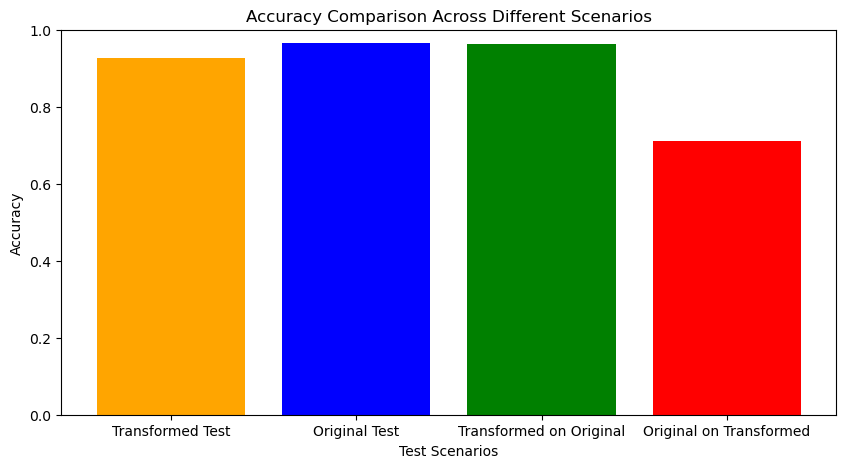

In [32]:
plt.figure(figsize=(10, 5))
plt.bar(labels, acc_data, color=['orange', 'blue', 'green', 'red'])
plt.ylim(0, 1)
plt.xlabel('Test Scenarios')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Different Scenarios')
plt.show()

In [34]:
loss_data = [
    transformed_test_loss,
    original_test_loss,
    transformed_on_original_loss,
    original_on_transformed_loss
]

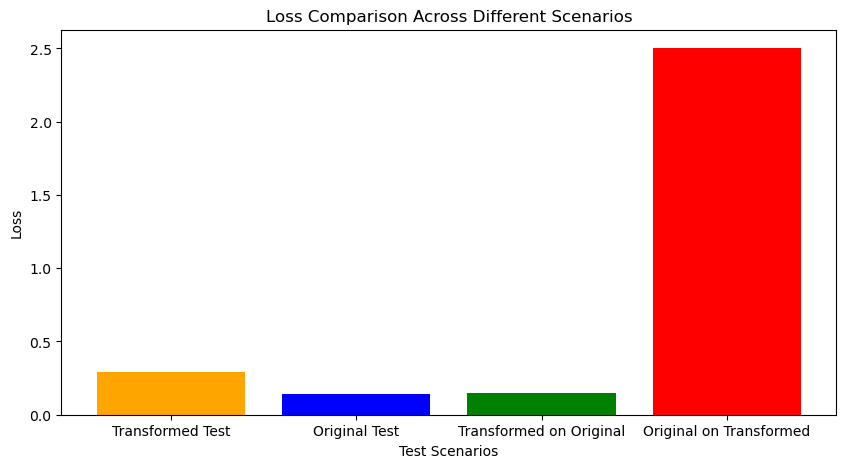

In [35]:
plt.figure(figsize=(10, 5))
plt.bar(labels, loss_data, color=['orange', 'blue', 'green', 'red'])
plt.xlabel('Test Scenarios')
plt.ylabel('Loss')
plt.title('Loss Comparison Across Different Scenarios')
plt.show()

It's evident that the model trained on the original, unaltered dataset struggles when sensor noise is present. What's interesting is that a model trained on the transformed data is able to retain a high testing accuracy, even on the unaltered data. This may mean that the the model trained on the transformed data has some sort of higher underlying complexity than the original model.